In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Check if we have GPU
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️ WARNING: No GPU detected. Training will be SLOW on CPU.")
    print("Consider using Google Colab with GPU for faster training.")


Using device: cpu
⚠️ WARNING: No GPU detected. Training will be SLOW on CPU.
Consider using Google Colab with GPU for faster training.


In [2]:
# Load processed data
print("📂 Loading processed data...")
X_train = pd.read_csv('../data/processed/X_train_scaled.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')['price']
X_test = pd.read_csv('../data/processed/X_test_scaled.csv')

# Load original data to get IDs for image matching
train_df = pd.read_excel('../data/raw/train.xlsx')
test_df = pd.read_excel('../data/raw/test.xlsx')

print(f"✅ X_train: {X_train.shape}")
print(f"✅ y_train: {y_train.shape}")
print(f"✅ X_test: {X_test.shape}")
print(f"✅ train_df IDs: {len(train_df)}")
print(f"✅ test_df IDs: {len(test_df)}")

# Check image availability
train_img_path = '../data/images/train'
test_img_path = '../data/images/test'

train_images = [f for f in os.listdir(train_img_path) if f.endswith('.jpg')]
test_images = [f for f in os.listdir(test_img_path) if f.endswith('.jpg')]

print(f"\n📸 Available train images: {len(train_images)}")
print(f"📸 Available test images: {len(test_images)}")


📂 Loading processed data...
✅ X_train: (16209, 35)
✅ y_train: (16209,)
✅ X_test: (5404, 35)
✅ train_df IDs: 16209
✅ test_df IDs: 5404

📸 Available train images: 16110
📸 Available test images: 5396


In [3]:
class PropertyDataset(Dataset):
    """Custom Dataset for Multimodal Property Valuation"""
    
    def __init__(self, df, tabular_features, targets, image_dir, transform=None):
        """
        Args:
            df: Original dataframe with 'id' column
            tabular_features: DataFrame of scaled tabular features
            targets: Series of target prices
            image_dir: Directory containing images
            transform: Image transformations
        """
        self.df = df.reset_index(drop=True)
        self.tabular_features = tabular_features.reset_index(drop=True)
        self.targets = targets.reset_index(drop=True) if targets is not None else None
        self.image_dir = image_dir
        self.transform = transform
        
        # Verify data alignment
        assert len(self.df) == len(self.tabular_features), "Data length mismatch!"
        if self.targets is not None:
            assert len(self.df) == len(self.targets), "Target length mismatch!"
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Get property ID
        property_id = self.df.loc[idx, 'id']
        
        # Load image
        img_path = os.path.join(self.image_dir, f"{property_id}.jpg")
        
        # Handle missing images with a black placeholder
        if os.path.exists(img_path):
            try:
                image = Image.open(img_path).convert('RGB')
            except:
                # If image is corrupted, use black placeholder
                image = Image.new('RGB', (400, 400), (0, 0, 0))
        else:
            # Missing image - use black placeholder
            image = Image.new('RGB', (400, 400), (0, 0, 0))
        
        if self.transform:
            image = self.transform(image)
        
        # Get tabular features
        tabular = torch.FloatTensor(self.tabular_features.iloc[idx].values)
        
        # Get target if available
        if self.targets is not None:
            target = torch.FloatTensor([self.targets.iloc[idx]])
            return image, tabular, target
        else:
            return image, tabular

# Define image transformations (optimized for CPU)
# Using 224x224 is standard for transfer learning
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Smaller than original for faster training
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("✅ Dataset class created!")
print("✅ Image transformations defined (224x224 for efficiency)")


✅ Dataset class created!
✅ Image transformations defined (224x224 for efficiency)


In [4]:
from sklearn.model_selection import train_test_split

# Split training data into train and validation (85/15 split)
train_idx, val_idx = train_test_split(
    range(len(train_df)), 
    test_size=0.15, 
    random_state=42
)

# Create train subset
train_subset_df = train_df.iloc[train_idx].reset_index(drop=True)
train_subset_X = X_train.iloc[train_idx].reset_index(drop=True)
train_subset_y = y_train.iloc[train_idx].reset_index(drop=True)

# Create validation subset
val_subset_df = train_df.iloc[val_idx].reset_index(drop=True)
val_subset_X = X_train.iloc[val_idx].reset_index(drop=True)
val_subset_y = y_train.iloc[val_idx].reset_index(drop=True)

print(f"Train size: {len(train_subset_df)}")
print(f"Validation size: {len(val_subset_df)}")

# Create datasets
train_dataset = PropertyDataset(
    train_subset_df, train_subset_X, train_subset_y,
    '../data/images/train', transform=train_transform
)

val_dataset = PropertyDataset(
    val_subset_df, val_subset_X, val_subset_y,
    '../data/images/train', transform=test_transform
)

test_dataset = PropertyDataset(
    test_df, X_test, None,
    '../data/images/test', transform=test_transform
)

# Create dataloaders (smaller batch size for CPU)
batch_size = 16  # Optimized for CPU
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"\n✅ Dataloaders created with batch_size={batch_size}")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")


Train size: 13777
Validation size: 2432

✅ Dataloaders created with batch_size=16
   Train batches: 862
   Val batches: 152
   Test batches: 338


In [9]:
class MultimodalPropertyModel(nn.Module):
    """
    Late Fusion Multimodal Model:
    - Image Branch: ResNet18 (pretrained on ImageNet)
    - Tabular Branch: Multi-layer Perceptron
    - Fusion: Concatenate embeddings and predict price
    """
    
    def __init__(self, num_tabular_features=35, image_embedding_dim=256, tabular_embedding_dim=128):
        super(MultimodalPropertyModel, self).__init__()
        
        # ========== IMAGE BRANCH (Transfer Learning) ==========
        resnet = models.resnet18(pretrained=True)
        
        # Freeze early layers
        for param in list(resnet.parameters())[:-10]:
            param.requires_grad = False
        
        # Remove the final classification layer
        self.image_feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
        
        # ResNet18 outputs 512 features
        self.image_fc = nn.Sequential(
            nn.Linear(512, image_embedding_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
            # Removed BatchNorm1d to avoid issues with small batch sizes
        )
        
        # ========== TABULAR BRANCH (MLP) ==========
        self.tabular_branch = nn.Sequential(
            nn.Linear(num_tabular_features, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(128, tabular_embedding_dim),
            nn.ReLU(),
            nn.Dropout(0.2)
            # Removed BatchNorm1d to avoid issues with small batch sizes
        )
        
        # ========== FUSION LAYER ==========
        fusion_input_dim = image_embedding_dim + tabular_embedding_dim
        self.fusion_layer = nn.Sequential(
            nn.Linear(fusion_input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(128, 1)  # Output: predicted price
        )
    
    def forward(self, images, tabular):
        # Process images
        img_features = self.image_feature_extractor(images)
        img_features = img_features.view(img_features.size(0), -1)  # Flatten
        img_embedding = self.image_fc(img_features)
        
        # Process tabular data
        tab_embedding = self.tabular_branch(tabular)
        
        # Concatenate embeddings (Late Fusion)
        fused = torch.cat([img_embedding, tab_embedding], dim=1)
        
        # Final prediction
        output = self.fusion_layer(fused)
        
        return output

# Initialize model
model = MultimodalPropertyModel(
    num_tabular_features=35,
    image_embedding_dim=256,
    tabular_embedding_dim=128
)

model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("=" * 60)
print("MULTIMODAL MODEL ARCHITECTURE (UPDATED)")
print("=" * 60)
print(f"✅ Model created successfully!")
print(f"📊 Total parameters: {total_params:,}")
print(f"🔧 Trainable parameters: {trainable_params:,}")
print(f"❄️  Frozen parameters: {total_params - trainable_params:,}")
print("\nArchitecture:")
print("  📸 Image Branch: ResNet18 (pretrained) → 256D embedding")
print("  📊 Tabular Branch: MLP → 128D embedding")
print("  🔗 Fusion: Late fusion → Price prediction")
print("  ✅ BatchNorm removed for CPU training stability")
print("=" * 60)


MULTIMODAL MODEL ARCHITECTURE (UPDATED)
✅ Model created successfully!
📊 Total parameters: 11,460,545
🔧 Trainable parameters: 5,005,697
❄️  Frozen parameters: 6,454,848

Architecture:
  📸 Image Branch: ResNet18 (pretrained) → 256D embedding
  📊 Tabular Branch: MLP → 128D embedding
  🔗 Fusion: Late fusion → Price prediction
  ✅ BatchNorm removed for CPU training stability


In [10]:
# Loss function and optimizer
criterion = nn.MSELoss()  # Use MSE for regression
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler (reduce LR if validation loss plateaus)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    
    # Progress bar
    pbar = tqdm(loader, desc="Training", leave=False)
    
    for images, tabular, targets in pbar:
        images, tabular, targets = images.to(device), tabular.to(device), targets.to(device)
        targets = targets.view(-1, 1)  # Reshape to [batch_size, 1]
        
        # Forward pass
        outputs = model(images, tabular)
        loss = criterion(outputs, targets)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        pbar.set_postfix({'loss': np.sqrt(loss.item())}) # Show RMSE
    
    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        pbar = tqdm(loader, desc="Validating", leave=False)
        for images, tabular, targets in pbar:
            images, tabular, targets = images.to(device), tabular.to(device), targets.to(device)
            targets = targets.view(-1, 1)
            
            outputs = model(images, tabular)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item() * images.size(0)
            
            all_preds.extend(outputs.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    epoch_loss = running_loss / len(loader.dataset)
    
    # Calculate R2 score manually
    y_true = np.array(all_targets).flatten()
    y_pred = np.array(all_preds).flatten()
    
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    return epoch_loss, r2, np.sqrt(epoch_loss)

print("✅ Training functions defined!")


✅ Training functions defined!


In [11]:
num_epochs = 3  # Reduced for CPU training (can increase if you have time)
best_val_loss = float('inf')
history = {'train_loss': [], 'val_loss': [], 'val_rmse': [], 'val_r2': []}

print(f"🚀 Starting training for {num_epochs} epochs on {device}...")
print(f"   Batch size: {batch_size}")
print(f"   Batches per epoch: {len(train_loader)}")

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    # Train
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_r2, val_rmse = validate(model, val_loader, criterion, device)
    
    # Update scheduler
    scheduler.step(val_loss)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_rmse'].append(val_rmse)
    history['val_r2'].append(val_r2)
    
    print(f"  Train Loss (MSE): {train_loss:.2f}")
    print(f"  Val Loss (MSE):   {val_loss:.2f}")
    print(f"  Val RMSE:         ${val_rmse:,.2f}")
    print(f"  Val R² Score:     {val_r2:.4f}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), '../outputs/models/best_multimodal_model.pth')
        print("  💾 Model saved! (New best)")

print("\n✅ Training complete!")
print(f"🏆 Best Validation RMSE: ${np.sqrt(best_val_loss):,.2f}")


🚀 Starting training for 3 epochs on cpu...
   Batch size: 16
   Batches per epoch: 862

Epoch 1/3


  Train Loss (MSE): 85373607906.86
  Val Loss (MSE):   29412755267.37
  Val RMSE:         $171,501.47
  Val R² Score:     0.7551
  💾 Model saved! (New best)

Epoch 2/3


  Train Loss (MSE): 33660695664.21
  Val Loss (MSE):   22621625037.47
  Val RMSE:         $150,404.87
  Val R² Score:     0.8116
  💾 Model saved! (New best)

Epoch 3/3


  Train Loss (MSE): 30193437156.95
  Val Loss (MSE):   21107589662.32
  Val RMSE:         $145,284.51
  Val R² Score:     0.8242
  💾 Model saved! (New best)

✅ Training complete!
🏆 Best Validation RMSE: $145,284.51


In [ ]:
import json
import os

# Continue training for 12 more epochs (Total 15)
extra_epochs = 12
print(f"🚀 Continuing training for {extra_epochs} more epochs to maximize R²...")

for epoch in range(3, 3 + extra_epochs): # Starting from epoch 3
    print(f"\nEpoch {epoch+1}/{3 + extra_epochs}")
    
    # Train
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_r2, val_rmse = validate(model, val_loader, criterion, device)
    
    # Update scheduler
    scheduler.step(val_loss)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_rmse'].append(val_rmse)
    history['val_r2'].append(val_r2)
    
    print(f"  Train Loss (MSE): {train_loss:.2f}")
    print(f"  Val Loss (MSE):   {val_loss:.2f}")
    print(f"  Val RMSE:         ${val_rmse:,.2f}")
    print(f"  Val R² Score:     {val_r2:.4f}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), '../outputs/models/best_multimodal_model.pth')
        print("  💾 Model saved! (New best)")
    else:
        print(f"  (Best was {np.sqrt(best_val_loss):,.2f})")

print("\n✅ Extended training complete!")
print(f"🏆 Final Best Validation RMSE: ${np.sqrt(best_val_loss):,.2f}")

# ============================================================
# Save training history to JSON for reproducibility
# ============================================================
print("\n💾 Saving training history...")
os.makedirs('../outputs', exist_ok=True)

with open('../outputs/training_history.json', 'w') as f:
    json.dump(history, f, indent=2)

print("✅ Training history saved to: outputs/training_history.json")
print(f"   - {len(history['train_loss'])} epochs logged")
print(f"   - Best RMSE: ${min(history['val_rmse']):,.2f}")
print(f"   - Best R²: {max(history['val_r2']):.4f}")


🚀 Continuing training for 12 more epochs to maximize R²...

Epoch 4/15


  Train Loss (MSE): 26753838225.75
  Val Loss (MSE):   20233769665.68
  Val RMSE:         $142,245.46
  Val R² Score:     0.8315
  💾 Model saved! (New best)

Epoch 5/15


  Train Loss (MSE): 26759707545.95
  Val Loss (MSE):   19609963279.16
  Val RMSE:         $140,035.58
  Val R² Score:     0.8367
  💾 Model saved! (New best)

Epoch 6/15


  Train Loss (MSE): 24514101357.52
  Val Loss (MSE):   19054786662.74
  Val RMSE:         $138,039.08
  Val R² Score:     0.8413
  💾 Model saved! (New best)

Epoch 7/15


  Train Loss (MSE): 23298392992.49
  Val Loss (MSE):   19222523034.95
  Val RMSE:         $138,645.31
  Val R² Score:     0.8399
  (Best was 138,039.08)

Epoch 8/15


  Train Loss (MSE): 21559418103.50
  Val Loss (MSE):   19370182703.16
  Val RMSE:         $139,176.80
  Val R² Score:     0.8387
  (Best was 138,039.08)

Epoch 9/15


  Train Loss (MSE): 20412452332.56
  Val Loss (MSE):   19475777293.47
  Val RMSE:         $139,555.64
  Val R² Score:     0.8378
  (Best was 138,039.08)

Epoch 10/15


  Train Loss (MSE): 18071254025.83
  Val Loss (MSE):   19732601524.21
  Val RMSE:         $140,472.78
  Val R² Score:     0.8357
  (Best was 138,039.08)

Epoch 11/15


  Train Loss (MSE): 17423333570.39
  Val Loss (MSE):   19348157554.53
  Val RMSE:         $139,097.65
  Val R² Score:     0.8389
  (Best was 138,039.08)

Epoch 12/15


  Train Loss (MSE): 16082962858.78
  Val Loss (MSE):   19241612810.11
  Val RMSE:         $138,714.14
  Val R² Score:     0.8398
  (Best was 138,039.08)

Epoch 13/15


  Train Loss (MSE): 15326106853.14
  Val Loss (MSE):   20301382644.21
  Val RMSE:         $142,482.92
  Val R² Score:     0.8309
  (Best was 138,039.08)

Epoch 14/15


  Train Loss (MSE): 14542353888.13
  Val Loss (MSE):   19801407093.89
  Val RMSE:         $140,717.47
  Val R² Score:     0.8351
  (Best was 138,039.08)

Epoch 15/15


  Train Loss (MSE): 14346956277.06
  Val Loss (MSE):   20182587978.11
  Val RMSE:         $142,065.44
  Val R² Score:     0.8319
  (Best was 138,039.08)

✅ Extended training complete!
🏆 Final Best Validation RMSE: $138,039.08


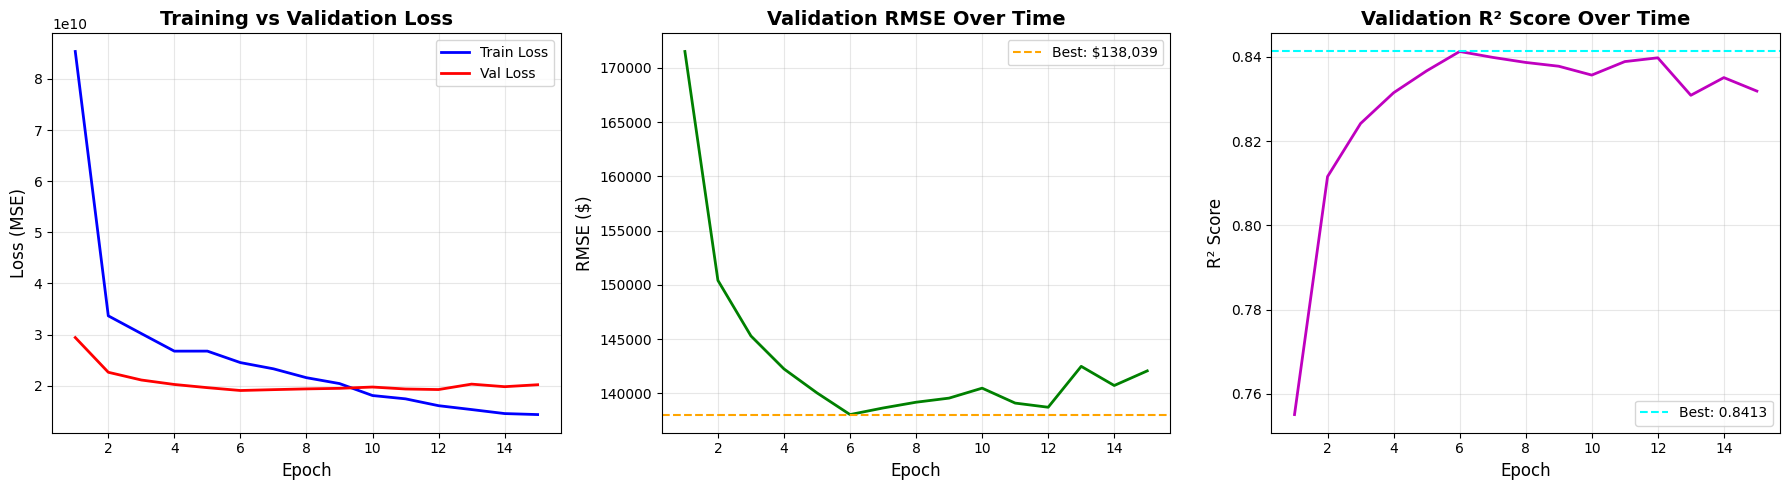

✅ Training history saved!
📊 Best RMSE: $138,039.08
📊 Best R²: 0.8413


In [5]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os

# Training history (recovered from training logs)
history = {
    "train_loss": [85373607906.86, 33660695664.21, 30193437156.95, 26753838225.75, 26759707545.95, 24514101357.52, 23298392992.49, 21559418103.50, 20412452332.56, 18071254025.83, 17423333570.39, 16082962858.78, 15326106853.14, 14542353888.13, 14346956277.06],
    "val_loss": [29412755267.37, 22621625037.47, 21107589662.32, 20233769665.68, 19609963279.16, 19054786662.74, 19222523034.95, 19370182703.16, 19475777293.47, 19732601524.21, 19348157554.53, 19241612810.11, 20301382644.21, 19801407093.89, 20182587978.11],
    "val_rmse": [171501.47, 150404.87, 145284.51, 142245.46, 140035.58, 138039.08, 138645.31, 139176.80, 139555.64, 140472.78, 139097.65, 138714.14, 142482.92, 140717.47, 142065.44],
    "val_r2": [0.7551, 0.8116, 0.8242, 0.8315, 0.8367, 0.8413, 0.8399, 0.8387, 0.8378, 0.8357, 0.8389, 0.8398, 0.8309, 0.8351, 0.8319]
}

# Save to file
os.makedirs('../outputs', exist_ok=True)
with open('../outputs/training_history.json', 'w') as f:
    json.dump(history, f, indent=2)

# Generate plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
epochs_range = range(1, len(history['train_loss']) + 1)

axes[0].plot(epochs_range, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
axes[0].plot(epochs_range, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0].set_title('Training vs Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(epochs_range, history['val_rmse'], 'g-', linewidth=2)
axes[1].axhline(y=min(history['val_rmse']), color='orange', linestyle='--', label=f'Best: ${min(history["val_rmse"]):,.0f}')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('RMSE ($)', fontsize=12)
axes[1].set_title('Validation RMSE Over Time', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(epochs_range, history['val_r2'], 'm-', linewidth=2)
axes[2].axhline(y=max(history['val_r2']), color='cyan', linestyle='--', label=f'Best: {max(history["val_r2"]):.4f}')
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('R² Score', fontsize=12)
axes[2].set_title('Validation R² Score Over Time', fontsize=14, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Training history saved!")
print(f"📊 Best RMSE: ${min(history['val_rmse']):,.2f}")
print(f"📊 Best R²: {max(history['val_r2']):.4f}")
